In [1]:
projectdir = "C:/Users/Arman Angaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(pwd())

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, Interact, LsqFit, CSV, Blink, Pipe, ProgressMeter, StatsPlots
pyplot()

try 
    Turnover
catch e
    include(projectdir*"Turnover/Turnover.jl")
    include(projectdir*"Turnover/test.jl")
    using .Turnover
end

import TumorGrowth
include("distribution_functions.jl")
plot(size=(1,1))

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-438937498679605765\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-9391580911505652378\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-438937498679605765\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

  Activating environment at `C:\Users\Arman Angaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1317
┌ Warning: Module Conda with build ID 242653932637915 is missing from the cache.
│ This may mean Conda [8f4d0f93-b110-5947-807f-2305c1781a2d] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1008
┌ Warning: Module Conda with build ID 242653932637915 is missing from the cache.
│ This may mean Conda [8f4d0f93-b110-5947-807f-2305c1781a2d] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1008
┌ Info: Skipping precompilation since __precompile__(false). Importing PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee].
└ @ Base loading.jl:1025
┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1317
┌ Warning: Module Conda wi

Test Summary:             | Pass  Total
Applying turnover methods |    7      7


┌ Info: Skipping precompilation since __precompile__(false). Importing PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0].
└ @ Base loading.jl:1025


In [2]:
try
    SeqDataFormatting
catch e
    include("experimental_data/SeqDataFormatting.jl")
    using .SeqDataFormatting
end

# Experimental Data

In [2]:
# mes2theory_orphaned(t_mes, p = [0.188, 17.688]) = @. p[1]*( 1/(1+exp(-p[2]*t_mes)) -1/2 )
# # mes2theory_orphaned(t_mes, p = [-0.264, 2.649]) = @. p[1] + p[2]*t_mes

# mes2theory_estranged(t_mes, p = [0.603, 1.267]) = map(t_mes) do t
# # mes2theory_estranged(t_mes, p = [0.804, 1.613]) = map(t_mes) do t
#     if p[1]/p[2] > 1/2 
#         10
#     else
#         t >= p[1] ? 1. : log( 1/ ( t*1/p[2] + 1/2 ) - 1 ) / log( 1/ ( p[1]/p[2] + 1/2 ) - 1)
#     end
# end

mes2theory_estranged (generic function with 2 methods)

In [3]:
function bisection(f, interval, iter; precision=1e-9)
    xlow, xup = interval
    sign(f(xlow)) == sign(f(xup)) && error("no zero in interval $interval")
    any((isnan.(f.(interval)))) && error("f not defined on interval $interval")
    for i=1:iter
        xm = (xlow+xup)/2
        abs(f(xm)) < precision && return (xm, i)
        if sign(f(xm)) != sign(f(xlow))
            xup = xm
        else
            xlow = xm
        end
    end
    println(xup)
    error("no convergence within $iter steps")
end

bisection (generic function with 1 method)

In [4]:
using Distributions, NLsolve, Roots
z = nlsolve(x->cdf.(Normal(), x) .- 0.975, [1.]).zero[1]

1.9599639704623484

## Sanger

In [10]:
sanger = TumorGrowth.data_import("experimental_data/LingProcessed/experimental_data_Sanger.csv"; delim=",")
sanger.frequencies = [ones(Float64, length(m)) for m in sanger.mutations];

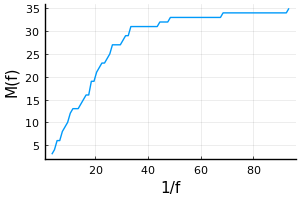

In [13]:
wes = TumorGrowth.data_import("experimental_data/LingProcessed/experimental_data_WES.csv", delim=",");
mtypes, mutations = TumorGrowth.clones_by_mutations(wes; res=0.0);
freqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.vaf[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )

res = 1/400
M(filter( f-> 0.8 > f > res, [freqs[m] for m=mutations]), nbins=50, lab="", size=(300,200))

### *sanger 'frequencies'*

In [6]:
# offspring_clade_fit, orphaned_clade_fit = [0, 2.0721200281841874], [0, 1.95984197842931]
# offspring_clone_fit, estranged_clone_fit = [0, 2.521358909445503], [0, 3.306604792822085]

# n 285, Nthresh_orph 285, Nthresh_estr 50, res 1/285, 1/3, sangerlike-freqs (samplenumbers)

offspring_clade_fit, orphaned_clade_fit, offspring_clone_fit, estranged_clone_fit = [0,1],[0,1],[0,1],[0,1]

function correct_orph(df_orph, p = [offspring_clade_fit, orphaned_clade_fit])
    max(0, sum(df_orph.isorphaned)- p[2][1]) / p[2][2] / max(0, sum(df_orph.isgreen) - p[1][1]) * p[1][2]
end
function correct_estr(df_estr, p = [offspring_clone_fit, estranged_clone_fit])
    max(0, sum(df_estr.isestranged)- p[2][1]) / p[2][2] / max(0, sum(df_estr.isgreen) - p[1][1]) * p[1][2]
end

correct_estr (generic function with 2 methods)

In [11]:
tumor = deepcopy(sanger)
params = (
    Nthresh_orph = 270,
    Nthresh_estr = 30,
    res = 1/270,
    )

freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict( df.mutation .=> df.frequency)

for row in eachrow(tumor)
    mask = row.frequencies .>= 1/Inf
    row.mutations = filter(m-> 1.1 > freqs[m] > params[:res], row.mutations[mask])
end

0.7118667034197714


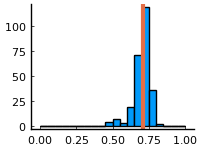

In [10]:
ds = map( 10:1:270) do M

    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/M, tumor.mutations) ) )
    
    # get d
    W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

    d_solve = min(1., 2*log(M)*W_l)
    end |> unique
histogram(ds, bins=0.:0.05:1., size=(200,150), lab="")
println(median(ds))
vline!([median(ds)], lab="", lw=3., grid=false)

In [12]:
orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/params[:Nthresh_orph], tumor.mutations) ) )

# get d
W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph #|> mes2theory_orphaned
#         df -> sum(df.isorphaned)/sum(df.isgreen) 

d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)

0.6708150382183199

In [13]:
d_solve = 0.67

0.67

In [14]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/params[:Nthresh_estr] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)

0.19326458037029162

In [15]:
estranged_treeless(estranged_tumor).isgreen |> sum

8.0

mean fit : 0.2251256301372722
averaged fits : 0.223872822180943 ± 0.0011818635949963692


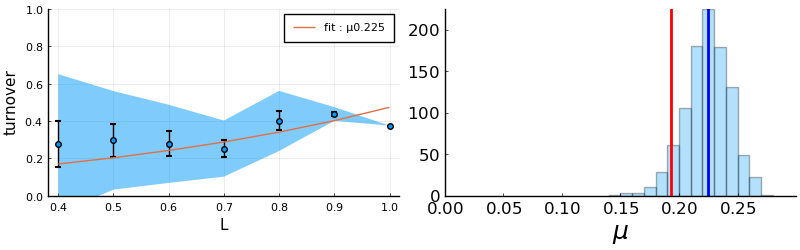

In [16]:
let d = d_solve
    Ls = 0.4:0.1:1.
    reps = 10
    estranged_tumors = map( Ls ) do L
        [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
    end

    estranged_turnover = map(estranged_tumors) do set
            filter!(!isnan, map(set) do tumor
                res = estranged_treeless(tumor)
                sum(res.isestranged)/sum(res.isgreen)
                end ) #|> mes2theory_estranged
        end

    Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
    
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, T=log(params[:Nthresh_estr])/(1-d)))
        end
    end
    fitres = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fitres.param[1]

#     p = plot(layout=(1,2), size=(800, 250), margin=5Plots.mm)
    p1 = scatter( Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:topright, ylim=(0,1))
    plot!(Ls, model(Ls, fitres.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram( mu_fits, lab="", alpha=0.3, xlim=(0,0.3), nbins=20, size=(400,250), ylim=(0,:auto))
    vline!([mu_fit], lab="", lw=2., c=:blue, tickfontsize=12, labelfontsize=18, xlab=L"\mu", grid=false )
    vline!([mu_solve], lab="", lw=2., c=:red)

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1,p2, size=(800,250))
    
#     savefig("Turnover/turnover_plots/experimental_data/sanger_sangerfreqs_mu.pdf")
end

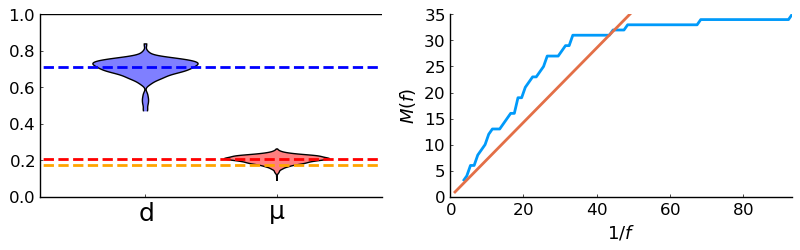

In [138]:
ds = map( 10:1:270) do M

    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/M, tumor.mutations) ) )
    
    # get d
    W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph #|> mes2theory_orphaned
    #         df -> sum(df.isorphaned)/sum(df.isgreen) 

    d_solve = min(1., 2*log(M)*W_l)
end |> unique
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/params[:Nthresh_estr] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 10
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = estranged_treeless(tumor)
            sum(res.isestranged)/sum(res.isgreen)
            end ) #|> mes2theory_estranged
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L, T=log(params[:Nthresh_estr])/(1-d_solve)))
    end
end
fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1)


p = plot(layout=(1,2), size=(800,250), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
# scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)

violin!(p[1], [2], mu_fits, c=:red, fillalpha=0.5)
# scatter!(p[1], [2], mu_fits, c=:red, alpha=0.5)
hline!(p[1], [median(mu_fits)], c=:red, lw=2., style=:dash)
hline!(p[1], [mu_solve], c=:orange, lw=2., style=:dash)

mtypes, mutations = TumorGrowth.clones_by_mutations(wes; res=0.0);
wesfreqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.vaf[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )

res = 1/400
plot!(p[2], tickfontsize=12, labelfontsize=13)
M!(p[2], filter( f-> 1 > f > res, [wesfreqs[m] for m=mutations]), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, :auto), ylim=(0,length(mutations)))
plot!(p[2], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

In [127]:
savefig("Turnover/turnover_plots/experimental_data/sanger_sangerfreqs.pdf")

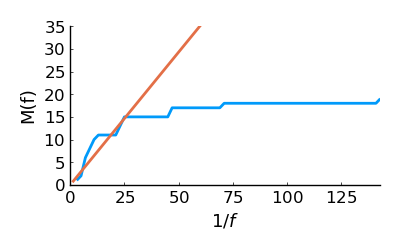

In [17]:
mtypes, mutations = TumorGrowth.clones_by_mutations(sanger; res=0.0);
freqs = TumorGrowth.mutation_freqs(sanger) |> df -> Dict(df.mutation .=> df.frequency)

res = 1/200
M(filter( f-> 1 > f > res, [freqs[m] for m=mutations]), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    labelfontsize=13, tickfontsize=12, grid=false, size=(400,250), margin=5Plots.mm, lw=2., xlim=(0, :auto), ylim=(0,length(mutations)))
plot!(1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

In [23]:
mu_solve = 0.193
d_solve = 0.67

0.67

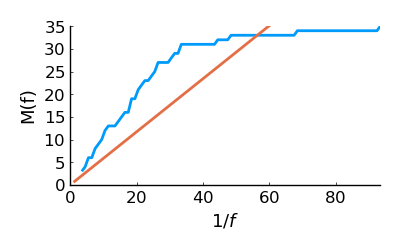

In [24]:
mtypes, mutations = TumorGrowth.clones_by_mutations(wes; res=0.0);
freqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.vaf[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )

res = 1/400
M(filter( f-> 1 > f > res, [freqs[m] for m=mutations]), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    labelfontsize=13, tickfontsize=12, grid=false, size=(400,250), margin=5Plots.mm, lw=2., xlim=(0, :auto), ylim=(0,length(mutations)))
plot!(1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

In [446]:
savefig("Turnover/turnover_plots/experimental_data/sanger_sangerfreqs_sfs.pdf")

### *wes frequencies*

In [7]:
# offspring_clade_fit, orphaned_clade_fit = [0, 0.3694065504550832], [0, 0.9337963349045757]
# offspring_clone_fit, estranged_clone_fit = [0, 0.27062540749285335], [0, 0.3815998563513362]

# n 30, Nthresh_orph 200, Nthresh_estr 50, res 1/200, 1/3

offspring_clade_fit, orphaned_clade_fit, offspring_clone_fit, estranged_clone_fit = [0,1],[0,1],[0,1],[0,1]

function correct_orph(df_orph, p = [offspring_clade_fit, orphaned_clade_fit])
    max(0, sum(df_orph.isorphaned)- p[2][1]) / p[2][2] / max(0, sum(df_orph.isgreen) - p[1][1]) * p[1][2]
end
function correct_estr(df_estr, p = [offspring_clone_fit, estranged_clone_fit])
    max(0, sum(df_estr.isestranged)- p[2][1]) / p[2][2] / max(0, sum(df_estr.isgreen) - p[1][1]) * p[1][2]
end

correct_estr (generic function with 2 methods)

In [8]:
Nscale = 1

1

In [14]:
params = (
        Nthresh_orph = 40,
        Nthresh_estr = 10,
        res = 1/40,
        )
tumor = deepcopy(sanger)

mutations = vcat(tumor.mutations...) |> unique
freqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.vaf[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )

for row in eachrow(tumor)
    mask = row.frequencies .>= 1/Inf
    row.mutations = filter(m-> 1.1 > freqs[m] > params[:res], row.mutations[mask])
end

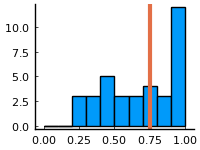

In [36]:
ds = map( 5:1:40) do M

    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/M, tumor.mutations) ) )
    

    # get d
    W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

    d_solve = min(1., 2*log(M*Nscale)*W_l)
end
histogram(ds, bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(ds)], lab="", lw=3., grid=false)

In [37]:
d_solve=0.75

0.75

In [38]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/params[:Nthresh_estr] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> correct_estr #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))- W_c, 0.01, 0.99)

0.19395235757179524

mean fit : 0.21211445467437198
averaged fits : 0.214873398990713 ± 0.003790679170568159


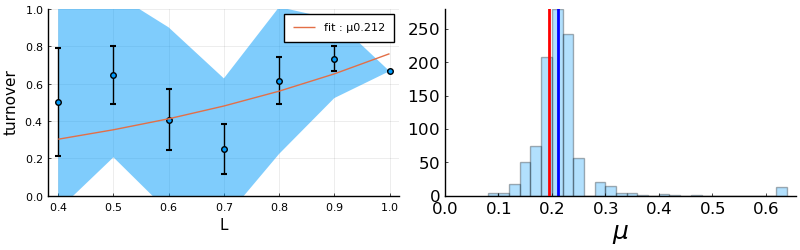

In [39]:
let d = d_solve
    Ls = 0.4:0.1:1.
    reps = 10
    estranged_tumors = map( Ls ) do L
        [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
    end

    estranged_turnover = map(estranged_tumors) do set
            filter!(!isnan, map(set) do tumor
                res = estranged_treeless(tumor)
                correct_estr(res)
                end ) 
        end

    Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
    
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, T=log(params[:Nthresh_estr]*Nscale)/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fit.param[1]

    p1 = scatter( Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:topright, ylim=(0,1))
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram( mu_fits, lab="", alpha=0.3, xlim=(0,:auto), nbins=30, size=(400,250), ylim=(0,:auto))
    vline!([mu_fit], lab="", lw=2., c=:blue, tickfontsize=12, labelfontsize=18, xlab=L"\mu", grid=false )
    vline!([mu_solve], lab="", lw=2., c=:red)

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1,p2, size=(800,250))

#     savefig("Turnover/turnover_plots/experimental_data/sanger_wesfreqs_mu.pdf")
end

In [157]:
Nscale = 5/1

5.0

1.0
0.0


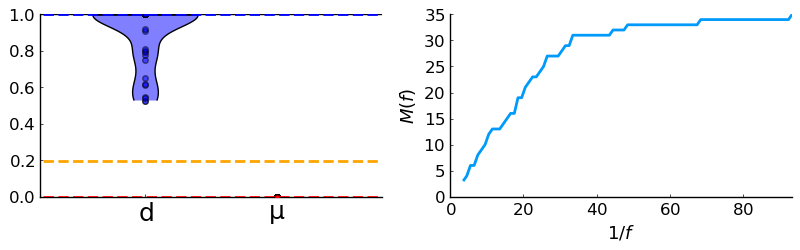

In [158]:
ds = map( 5:1:40) do M

    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/M, tumor.mutations) ) )
    # get d
    W_l = orphaned_tumor |> orphaned_red_treeless |> correct_orph #|> mes2theory_orphaned

    min(1., 2*log(M*Nscale)*W_l)
    end# |> unique
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/params[:Nthresh_estr] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> correct_estr #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))- W_c, [0.01,0.99], 100)
# mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 10
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> correct_estr)
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))
    end
end
fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1)


p = plot(layout=(1,2), size=(800,250), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

violin!(p[1], [2], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[1], [2], mu_fits, c=:red, alpha=0.5)
hline!(p[1], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits))
hline!(p[1], [mu_solve], c=:orange, lw=2., style=:dash)

mtypes, mutations = TumorGrowth.clones_by_mutations(wes; res=0.0);
freqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.vaf[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )

res = 1/400
plot!(p[2], tickfontsize=12, labelfontsize=13)
M!(p[2], filter( f-> 1 > f > res, [freqs[m] for m=mutations]), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, :auto), ylim=(0,length(mutations)))
plot!(p[2], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

0.7494154434939191
0.21300693096508044


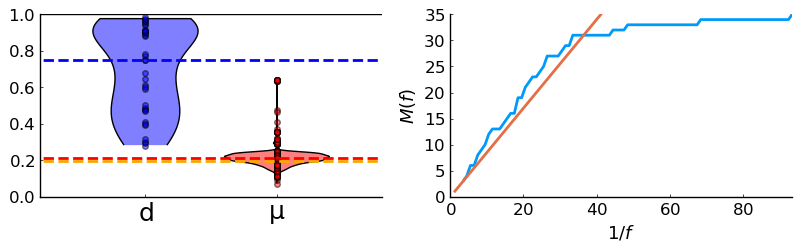

In [53]:
ds = map( 5:1:40) do M

    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/M, tumor.mutations) ) )
    # get d
    W_l = orphaned_tumor |> orphaned_red_treeless |> correct_orph #|> mes2theory_orphaned

    min(1., 2*log(M*Nscale)*W_l)
    end# |> unique
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/params[:Nthresh_estr] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> correct_estr #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))- W_c, [0.01,0.99], 100)
# mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 10
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> correct_estr)
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))
    end
end
fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1)


p = plot(layout=(1,2), size=(800,250), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

violin!(p[1], [2], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[1], [2], mu_fits, c=:red, alpha=0.5)
hline!(p[1], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits))
hline!(p[1], [mu_solve], c=:orange, lw=2., style=:dash)

mtypes, mutations = TumorGrowth.clones_by_mutations(wes; res=0.0);
freqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.vaf[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )

res = 1/400
plot!(p[2], tickfontsize=12, labelfontsize=13)
M!(p[2], filter( f-> 1 > f > res, [freqs[m] for m=mutations]), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, :auto), ylim=(0,length(mutations)))
plot!(p[2], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

In [133]:
# savefig("Turnover/turnover_plots/experimental_data/sanger_wesfreqs.pdf")

In [43]:
mu_solve = 0.2
mu_solve/(1-d_solve)

0.8

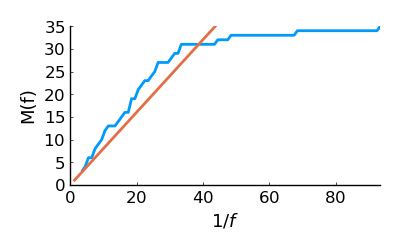

In [44]:
mtypes, mutations = TumorGrowth.clones_by_mutations(wes; res=0.0);
freqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.vaf[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )

res = 1/400
M(filter( f-> 1 > f > res, [freqs[m] for m=mutations]), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    labelfontsize=13, tickfontsize=12, grid=false, size=(400,250), margin=5Plots.mm, lw=2., xlim=(0, :auto), ylim=(0,length(mutations)))
plot!(1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

In [458]:
savefig("Turnover/turnover_plots/experimental_data/sanger_wesfreqs_sfs.pdf")

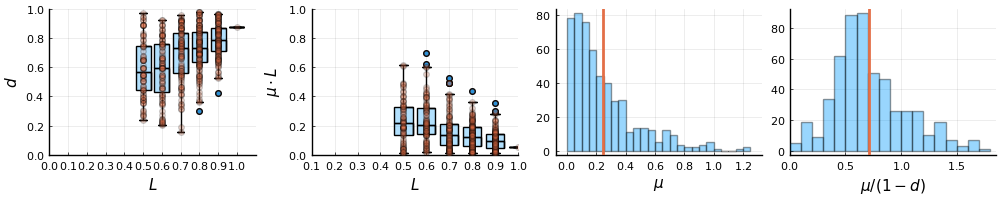

In [143]:
params = (
    Nthresh_orph =35,
    Nthresh_estr = 10,
    res = 1/35,
    )

mutations = vcat(sanger.mutations...) |> unique
freqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.frequencies[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )
results = Vector()
Ls = Float64[]
for L = 0.5:0.1:1.
    for _=1:200
        tumor = deepcopy(select(sanger, :mutations))
        
        selection = sample(mutations, floor(Int, length(mutations)*L), replace =false)
        filter!.(m -> m in selection, tumor.mutations)
        
#         freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict( df.mutation .=> df.frequency)
        
        filter!.(m-> 1.1 > freqs[m] > params[:res], tumor.mutations)

        htypes = unique(tumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/params[:Nthresh_orph], htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/params[:Nthresh_estr] for m in muts), htypes) )

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph #|> mes2theory_orphaned
        
        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        
        (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr #|> mes2theory_estranged
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve ≈ 0.99 && continue
            
            push!(results, (d_solve, mu_solve))
            push!(Ls, L)
            L==1. && break
            catch e
        end
        
    end
end
p = plot(layout=(1,4), legend=:none, size=(1000,200))
scalex = 10

boxplot!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"d")
# hline!(p[1], [mean(getindex.(results, 1))], lw=2.)

boxplot!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(4,scalex), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
# plot!(p[2], [0,scalex], [0,last(results)[2]], lw=2.)

histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )

slope = filter(x -> x< 4, getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))

histogram!(p[4], slope, xlim=(0,:auto), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
vline!(p[4], [mean(slope)], lw=2. )

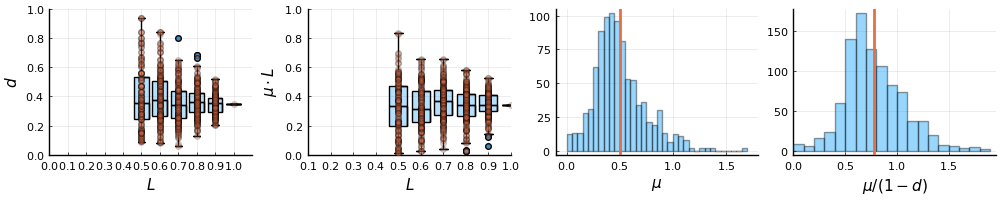

In [141]:
params = (
    Nthresh_orph =35,
    Nthresh_estr = 10,
    res = 1/35,
    )

mutations = vcat(sanger.mutations...) |> unique
freqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.frequencies[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )
results = Vector()
Ls = Float64[]
for L = 0.5:0.1:1.
    for _=1:200
        tumor = deepcopy(select(sanger, :mutations))
        
        selection = sample(mutations, floor(Int, length(mutations)*L), replace =false)
        filter!.(m -> m in selection, tumor.mutations)
        
#         freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict( df.mutation .=> df.frequency)
        
        filter!.(m-> 1.1 > freqs[m] > params[:res], tumor.mutations)

        htypes = unique(tumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/params[:Nthresh_orph], htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/params[:Nthresh_estr] for m in muts), htypes) )

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph #|> mes2theory_orphaned
        
        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        
        (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr #|> mes2theory_estranged
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve ≈ 0.99 && continue
            
            push!(results, (d_solve, mu_solve))
            push!(Ls, L)
            L==1. && break
            catch e
        end
        
    end
end
p = plot(layout=(1,4), legend=:none, size=(1000,200))
scalex = 10

boxplot!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"d")
# hline!(p[1], [mean(getindex.(results, 1))], lw=2.)

boxplot!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(4,scalex), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
# plot!(p[2], [0,scalex], [0,last(results)[2]], lw=2.)

histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )

slope = filter(x -> x< 4, getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))

histogram!(p[4], slope, xlim=(0,:auto), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
vline!(p[4], [mean(slope)], lw=2. )

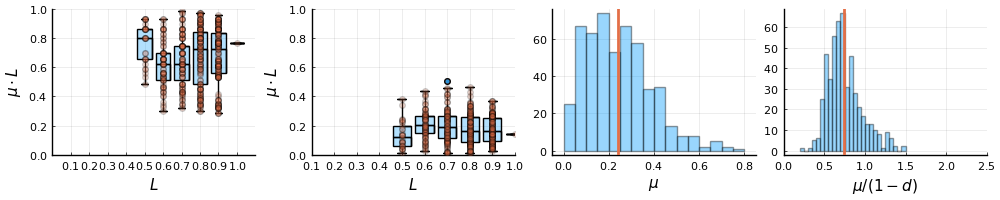

In [138]:
params = (
    Nthresh_orph = 270,
    Nthresh_estr = 30,
    res = 1/270,
    )

mutations = vcat(sanger.mutations...) |> unique
results = Vector()
Ls = Float64[]
for L = 0.5:0.1:1.
    for _=1:200
        tumor = deepcopy(select(sanger, :mutations))
        
        selection = sample(mutations, floor(Int, length(mutations)*L), replace =false)
        filter!.(m -> m in selection, tumor.mutations)
        
        freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict( df.mutation .=> df.frequency)
        
        filter!.(m-> 1.1 > freqs[m] > params[:res], tumor.mutations)

        htypes = unique(tumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/params[:Nthresh_orph], htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/params[:Nthresh_estr] for m in muts), htypes) )

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen) #|> mes2theory_orphaned
        
        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        
        (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen) #|> mes2theory_estranged
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve ≈ 0.99 && continue
            
            push!(results, (d_solve, mu_solve))
            push!(Ls, L)
            L==1. && break
            catch e
        end
        
    end
end
p = plot(layout=(1,4), legend=:none, size=(1000,200))
scalex = 10

boxplot!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
# hline!(p[1], [mean(getindex.(results, 1))], lw=2.)

boxplot!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(4,scalex), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
# plot!(p[2], [0,scalex], [0,last(results)[2]], lw=2.)

histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )
histogram!(p[4], getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)), xlim=(0,2.5), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
vline!(p[4], [mean(getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))], lw=2. )

In [428]:
# savefig("C:/Users/Arman Angaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Thesis/latex/chapters/Results/figures/results/LingSangerTurnover.pdf")

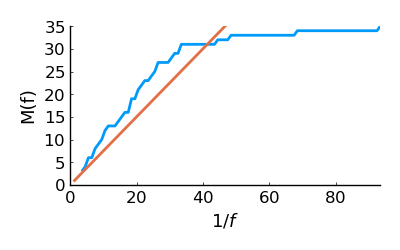

In [140]:
mtypes, mutations = TumorGrowth.clones_by_mutations(wes; res=0.0);
freqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.vaf[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )

res = 1/400
M(filter( f-> 1 > f > res, [freqs[m] for m=mutations]), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    labelfontsize=13, tickfontsize=12, grid=false, size=(400,250), margin=5Plots.mm, lw=2., xlim=(0, :auto), ylim=(0,length(mutations)))

plot!(1:80, x-> x*0.75, lw=2., lab="")

## Reanalyzed data (pairwise calls)

In [159]:
sampleinfo = TumorGrowth.data_import("experimental_data/wes_sampleinfo.csv", delim=",")
normal = "N1"
tumorsamples = sampleinfo.samplename
samples = [tumorsamples..., normal]

mutations_string = CSV.read("experimental_data/MichelProcessed/Ling2015_pairwise_median.csv", DataFrame)
mutations_string = CSV.read("experimental_data/MichelProcessed/Ling2015_pairwise_median.csv", DataFrame)
seqdata = SeqDataFormatting.string_to_seqresult(mutations_string, samples);

In [160]:
ccf_raw = seqdata_to_tumor(seqdata, sampleinfo; normal = "N1", 
    maxReadsNormal = 0, 
    minReads = 5,
    minCoverage = 15,
    maxCoverage = Inf,
    cnaAgreement = 22)
ccf_raw.frequencies = copy(ccf_raw.ccf);
vcat(ccf_raw.mutations...) |> unique |> length

676

In [161]:
ccf = deepcopy(ccf_raw);

In [162]:
function load_turnovertumors(data_raw; mutnumb = 10000, Nthresh_orph = 10000, Nthresh_estr = Nthresh_orph, clonalcutoff = 1., res = 0., sample_cutoff = 0.)
    tumor = deepcopy(data_raw)
    mutations = unique!(vcat(tumor.mutations...))
    subset = sample(mutations, min(mutnumb, length(mutations)), replace = false)

    freqs = SeqDataFormatting.mfreqs(tumor) |> df -> Dict(df.mutation .=> df.frequency)
    for sample in eachrow(tumor)
        mask = map(zip(sample.frequencies, sample.mutations)) do (f,m)
                m in subset && (f >= sample_cutoff) &&  (1. >= freqs[m] > res)
            end
        
        sample.mutations = copy(sample.mutations[mask])
        sample.frequencies = copy(sample.frequencies[mask])
        sample.vaf = copy(sample.vaf[mask])
        sample.ccf = copy(sample.ccf[mask])
        sample.reads = copy(sample.reads[mask])
        sample.cna = copy(sample.cna[mask])
        sample.ploidy = copy(sample.ploidy[mask])
        sample.coverage = copy(sample.coverage[mask])
    end

    htypes = unique(tumor.mutations)
    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh_orph, htypes) ) )
    estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh_estr for m in muts), htypes) )
    (tumor = tumor, orphaned_tumor = orphaned_tumor, estranged_tumor = estranged_tumor)
end

load_turnovertumors (generic function with 1 method)

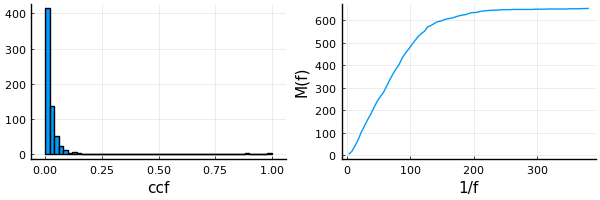

In [60]:
include("distribution_functions.jl")
ccf, _ = load_turnovertumors(ccf_raw; mutnumb = 1000, Nthresh_orph = 10000, res = 0, sample_cutoff = 0.)
mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

res = 1/400
plot( 
    histogram(filter( f-> 1. > f > res, [freqs[m] for m=mutations]), nbins=50, lab="", xlab=:ccf),
    M(filter( f-> 0.7 > f > res, [freqs[m] for m=mutations]), nbins=50, lab=""),
    size=(600,200)
)

#### PARAMETERS

In [64]:
3*23

69

In [83]:
params = (
    Nthresh_orph = 70,
    Nthresh_estr = 20,
    sample_cutoff = 1/3,
    res = 1/( 3 * nrow(ccf) ),
)

(Nthresh_orph = 70, Nthresh_estr = 20, sample_cutoff = 0.3333333333333333, res = 0.014492753623188406)

### single tumor

In [66]:
mutnumb = 150

150

In [74]:
ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)

# get d
W_l = orphaned_red_treeless(orphaned_tumor) |>
        df -> sum(df.isorphaned)/sum(df.isgreen)

d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)

0.887745274458075

In [271]:
# get mu
Ls = 0.1:0.1:1.
reps = 10
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = estranged_treeless(tumor)
            sum(res.isestranged)/sum(res.isgreen)
        end )
    end

Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1, μ=mu*L, T=log(params[:Nthresh_estr])/(1-d_solve)))
    end
end

fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
mu_fit = fitres.param[1]

0.28886281312408735

mean fit : 0.28886281312408735
averaged fits : 0.2885291487570911 ± 0.001385201407542911


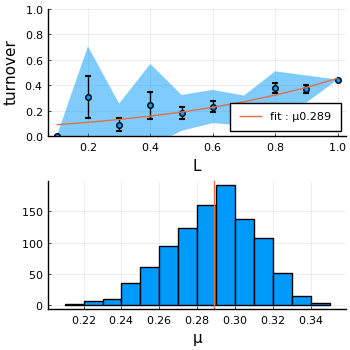

In [272]:
let d = d_solve
    t = estranged_turnover
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, T=log(params[:Nthresh_estr])/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fit.param[1]

    p1 = scatter(Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:bottomright, ylim=(0,1))
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram(mu_fits, xlab="μ", lab="")
    vline!([mu_fit], lab="")

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1, p2, layout=(2,1), size=(350,350))
end

In [273]:
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen)

mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
# mu_solve = fzero(mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, 0.01, 0.99)

(0.28499225880950685, 29)

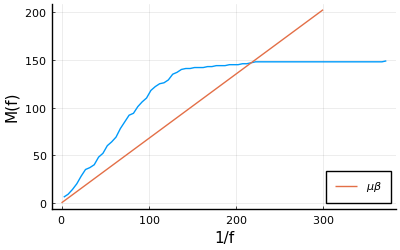

In [276]:
ccf, _ = load_turnovertumors(ccf_raw; mutnumb = mutnumb, res = 0)
ccf.frequencies = ccf.ccf;

mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

M([freqs[m] for m=mutations], nbins=50, lab="", size=(400,250))
plot!(0:300, x-> x*mu_solve/(1-d_solve), lab=L"\mu \beta", legend=:bottomright)

## Subsampling single tumor

In [75]:
# offspring_clade_fit, orphaned_clade_fit = [-3.1393344953000137, 0.3694065504550832], [0.28213233319606085, 0.9337963349045757]
# offspring_clone_fit, estranged_clone_fit = [2.0460394588109088, 0.27062540749285335], [1.742873794475777, 0.3815998563513362]

# n 30, Nthresh_orph 200, Nthresh_estr 50, res 1/200, 1/3

offspring_clade_fit, orphaned_clade_fit, offspring_clone_fit, estranged_clone_fit = [0,1],[0,1],[0,1],[0,1]

function correct_orph(df_orph, p = [offspring_clade_fit, orphaned_clade_fit])
    max(0, sum(df_orph.isorphaned)- p[2][1]) / p[2][2] / (sum(df_orph.isgreen) - p[1][1]) * p[1][2]
end
function correct_estr(df_estr, p = [offspring_clone_fit, estranged_clone_fit])
    max(0, sum(df_estr.isestranged)- p[2][1]) / p[2][2] / (sum(df_estr.isgreen) - p[1][1]) * p[1][2]
end

correct_estr (generic function with 2 methods)

### relative death rate $d/b$

0.7596759876464403
30 %


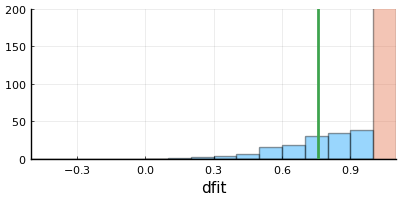

In [89]:
let mutnumb = 200
    dsolves = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph #|> mes2theory_orphaned

        min(1., 2*log(params[:Nthresh_orph])*W_l)
    end
    histogram(dsolves, legend=:none, size=(400,200), alpha=0.4, bins=0:0.1:1, xlim=(-0.5,1.1), ylim=(0,200), xlab=:dfit)
    histogram!(filter(x-> !(1>x>0), dsolves), legend=:none, size=(400,200), bins = -1:0.1:2, alpha=0.4)
    results = filter(x-> 1>x>0, dsolves)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(dsolves)*100 ), " %")
    plot!()
end

> uncorrected

0.5466309566108125
96 %


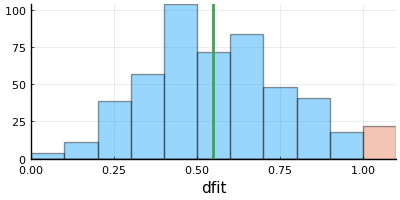

In [18]:
let mutnumb = 200
    dsolves = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

        min(1., 2*log(params[:Nthresh_orph])*W_l)
    end
    histogram(dsolves, legend=:none, size=(400,200), alpha=0.4, bins=0:0.1:1, xlim=(-0.0,1.1), ylim=(0,:auto), xlab=:dfit)
    histogram!(filter(x-> !(1>x>0), dsolves), legend=:none, size=(400,200), bins = -1:0.1:2, alpha=0.4)
    results = filter(x-> 1>x>0, dsolves)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(dsolves)*100 ), " %")
    plot!()
end

0.595700503804289
100 %


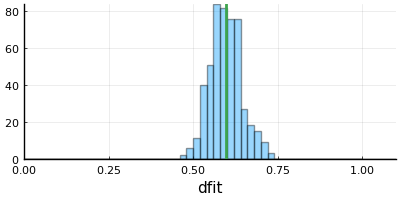

In [21]:
let mutnumb = 600
    dsolves = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

        min(1., 2*log(params[:Nthresh_orph])*W_l)
    end
    histogram(dsolves, legend=:none, size=(400,200), alpha=0.4, bins=0:0.02:1, xlim=(-0.0,1.1), ylim=(0,:auto), xlab=:dfit)
    histogram!(filter(x-> !(1>x>0), dsolves), legend=:none, size=(400,200), bins = -1:0.1:2, alpha=0.4)
    results = filter(x-> 1>x>0, dsolves)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(dsolves)*100 ), " %")
    plot!()
end

> corrected

In [91]:
d_solve = 0.76
1/(1-d_solve)

4.166666666666667

In [354]:
mes2theory_orphaned(1) |> println
2*log(params[:Nthresh_orph])*mes2theory_orphaned(1) |> println

0.09399999608837653
0.9419993960906589


### mutation rate $\mu$

### *fit*

0.13468046056483132
100 %


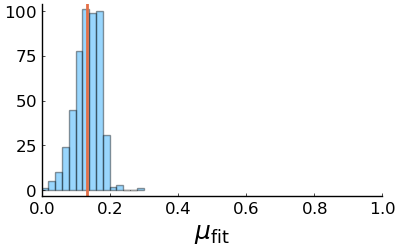

In [86]:
let mutnumb = 300
    mufits = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get mu

        Ls = 0.1:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    estranged_treeless(tumor) |> correct_estr #|> mes2theory_estranged
                    end ) 
            end

        Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d_solve; b=1, μ=mu*L, T=log(params[:Nthresh_estr])/(1-d_solve)))
            end
        end

        fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
        fitres.param[1] ≈ (1-d_solve)/2 ? 1. : fitres.param[1]
    end
    histogram(mufits, legend=:none, size=(400,250), nbins=20, alpha=0.4, xlim=(0,1), xlab=L"\mu_{\mathrm{fit}}", tickfontsize=12, labelfontsize=18, grid=false)
    results = filter(x-> !(iszero(x) || isone(x)), mufits)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(mufits)*100 ), " %")
    plot!()
end

0.14367272045722315
100 %


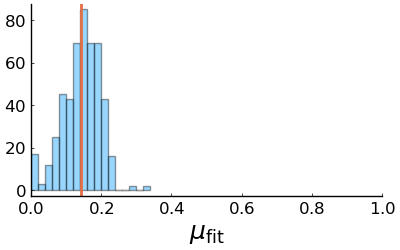

In [92]:
let mutnumb = 200
    mufits = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get mu

        Ls = 0.1:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    estranged_treeless(tumor) |> correct_estr #|> mes2theory_estranged
                    end ) 
            end

        Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d_solve; b=1, μ=mu*L, T=log(params[:Nthresh_estr])/(1-d_solve)))
            end
        end

        fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
        fitres.param[1] ≈ (1-d_solve)/2 ? 1. : fitres.param[1]
    end
    histogram(mufits, legend=:none, size=(400,250), nbins=20, alpha=0.4, xlim=(0,1), xlab=L"\mu_{\mathrm{fit}}", tickfontsize=12, labelfontsize=18, grid=false)
    results = filter(x-> !(iszero(x) || isone(x)), mufits)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(mufits)*100 ), " %")
    plot!()
end

> uncorrected

0.15782786750915617
100 %


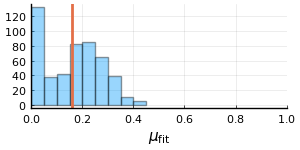

In [20]:
let mutnumb = 200
    mufits = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get mu

        Ls = 0.1:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    estranged_treeless(tumor) |> correct_estr #|> mes2theory_estranged
                    end )
            end

        Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d_solve; b=1, μ=mu*L, T=log(params[:Nthresh_estr])/(1-d_solve)))
            end
        end

        fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
        fitres.param[1] == (1-d_solve)/2 ? 1. : fitres.param[1]
    end
    histogram(mufits, legend=:none, size=(300,150), alpha=0.4, xlim=(0,1), xlab=L"\mu_{\mathrm{fit}}")
    results = filter(x-> !(iszero(x) || isone(x)), mufits)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(mufits)*100 ), " %")
    plot!()
end

0.3304247466327661
100 %


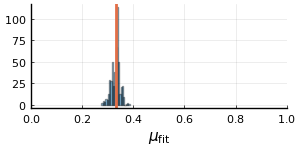

In [24]:
let mutnumb = 600
    mufits = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get mu

        Ls = 0.1:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    estranged_treeless(tumor) |> correct_estr #|> mes2theory_estranged
                    end )
            end

        Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d_solve; b=1, μ=mu*L, T=log(params[:Nthresh_estr])/(1-d_solve)))
            end
        end

        fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
        fitres.param[1] == (1-d_solve)/2 ? 1. : fitres.param[1]
    end
    histogram(mufits, legend=:none, size=(300,150), alpha=0.4, xlim=(0,1), xlab=L"\mu_{\mathrm{fit}}")
    results = filter(x-> !(iszero(x) || isone(x)), mufits)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(mufits)*100 ), " %")
    plot!()
end

> corrected

0.22121497189969236
20 %
0.7577293379595821


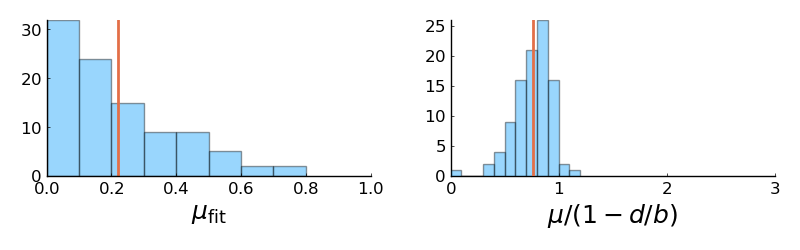

In [386]:
let mutnumb = 200
    fits = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        
        # get mu

        Ls = 0.1:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    estranged_treeless(tumor) |> correct_estr # |> mes2theory_estranged
                    end )
            end

        Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d_solve; b=1, μ=mu*L, T=log(params[:Nthresh_estr])/(1-d_solve)))
            end
        end

        fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
        (fitres.param[1] ≈ (1-d_solve)/2 ? 1. : fitres.param[1] , fitres.param[1]/(1-d_solve))
    end
    
    results = filter(x-> !(iszero(x[1]) || isone(x[1])), fits)
    
    p = plot(layout=(1,2), size=(800,250), legend=:none, tickfontsize=12, labelfontsize=18, grid=false, ylims=(0,:auto), margin=5Plots.mm)
    
    histogram!(p[1], getindex.(results,1), nbins=10, alpha=0.4, xlim=(0,1), xlab=L"\mu_{\mathrm{fit}}")
    vline!(p[1], [mean(getindex.(results,1))], lw=2.)
    println(mean(getindex.(results,1)))
    println(ceil(Int, length(results)/length(fits)*100 ), " %")
    histogram!(p[2], getindex.(results,2), alpha=0.4, xlim=(0,3), xlab=L"\mu/(1-d/b)")
    vline!(p[2], [mean(getindex.(results,2))], lw=2.)
    println(mean(getindex.(results,2)))
    p
end

0.3337489755522227
100 %
0.8217015624453389


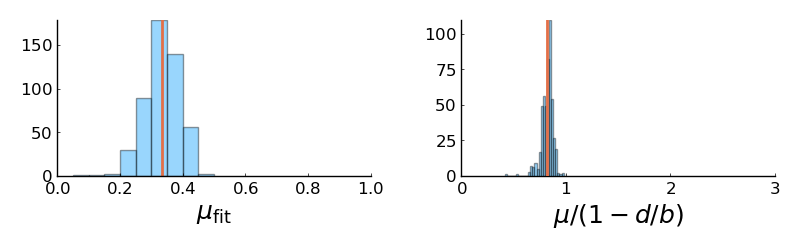

In [455]:
let mutnumb = 600
    fits = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        
        # get mu

        Ls = 0.1:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    estranged_treeless(tumor) |> correct_estr # |> mes2theory_estranged
                    end )
            end

        Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d_solve; b=1, μ=mu*L, T=log(params[:Nthresh_estr])/(1-d_solve)))
            end
        end

        fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
        (fitres.param[1] ≈ (1-d_solve)/2 ? 1. : fitres.param[1] , fitres.param[1]/(1-d_solve))
    end
    
    results = filter(x-> !(iszero(x[1]) || isone(x[1])), fits)
    
    p = plot(layout=(1,2), size=(800,250), legend=:none, tickfontsize=12, labelfontsize=18, grid=false, ylims=(0,:auto), margin=5Plots.mm)
    
    histogram!(p[1], getindex.(results,1), nbins=10, alpha=0.4, xlim=(0,1), xlab=L"\mu_{\mathrm{fit}}")
    vline!(p[1], [mean(getindex.(results,1))], lw=2.)
    println(mean(getindex.(results,1)))
    println(ceil(Int, length(results)/length(fits)*100 ), " %")
    histogram!(p[2], getindex.(results,2), alpha=0.4, xlim=(0,3), xlab=L"\mu/(1-d/b)")
    vline!(p[2], [mean(getindex.(results,2))], lw=2.)
    println(mean(getindex.(results,2)))
    p
end

### *solve*

0.1720896610681945
100 %


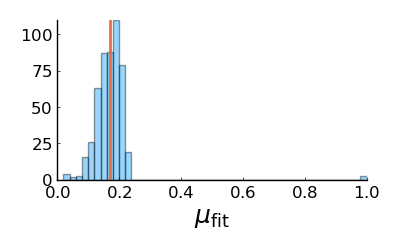

In [408]:
let mutnumb = 200
    mufits = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr
    
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
        catch e
            1.
        end
                
    end
    
    results = filter(x-> !(iszero(x) || isone(x)), mufits)
    histogram(results, legend=:none, size=(400,250), alpha=0.4, xlim=(0,1), xlab=L"\mu_{\mathrm{fit}}",
        tickfontsize=12, labelfontsize=18, grid=false, ylims=(0,:auto), margin=5Plots.mm)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(mufits)*100 ), " %")
    plot!()
end

> uncorrected

0.2315082657281024
86 %


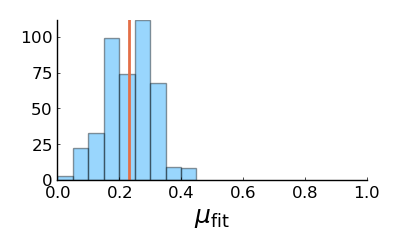

In [182]:
let mutnumb = 200
    mufits = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr
    
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
        catch e
            1.
        end
                
    end
    
    results = filter(x-> !(iszero(x) || isone(x)), mufits)
    histogram(results, legend=:none, size=(400,250), alpha=0.4, xlim=(0,1), xlab=L"\mu_{\mathrm{fit}}",
        tickfontsize=12, labelfontsize=18, grid=false, ylims=(0,:auto), margin=5Plots.mm)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(mufits)*100 ), " %")
    plot!()
end

0.2969984167865296
100 %


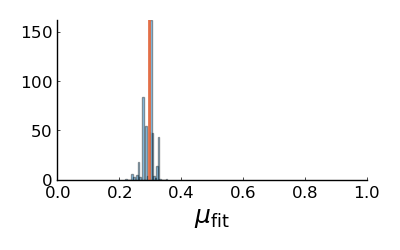

In [456]:
let mutnumb = 600
    mufits = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr
    
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
        catch e
            1.
        end
                
    end
    
    results = filter(x-> !(iszero(x) || isone(x)), mufits)
    histogram(results, legend=:none, size=(400,250), alpha=0.4, xlim=(0,1), xlab=L"\mu_{\mathrm{fit}}",
        tickfontsize=12, labelfontsize=18, grid=false, ylims=(0,:auto), margin=5Plots.mm)
    vline!([mean(results)], lw=2.)
    println(mean(results))
    println(ceil(Int, length(results)/length(mufits)*100 ), " %")
    plot!()
end

> corrected

In [475]:
d_solve = 0.7
mu_solve = 0.23
mu_solve/(1-d_solve)

0.7666666666666666

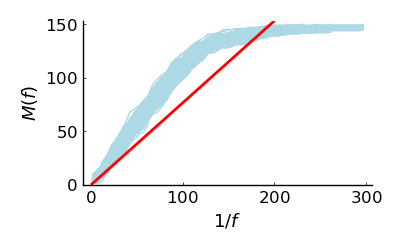

In [476]:
let mutnumb = 150
    fig = plot(size=(400,250), legend=:none, tickfontsize=12, labelfontsize=13, grid=false, ylims=(0,:auto), margin=5Plots.mm)
    for _=1:200
        ccf, _ = load_turnovertumors(ccf_raw; mutnumb = mutnumb, Nthresh_orph = 10000, res = 0, sample_cutoff = 0)

        mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

        M!(fig, [freqs[m] for m=mutations], nbins=50, lab="", size=(400,250), res=1/300, c=:lightblue, xlab=L"1/f", ylab=L"M(f)")
        
    end
#     plot!(0:1/params[:res], x-> x*2*mu_solve/(1-d_solve), lab=L"\mu \beta", legend=:bottomright, lw=1.5, c=:red, alpha=0.2)
    plot!(0:200, x-> x*mu_solve/(1-d_solve), lab=L"\mu \beta", lw=2., c=:red)
end

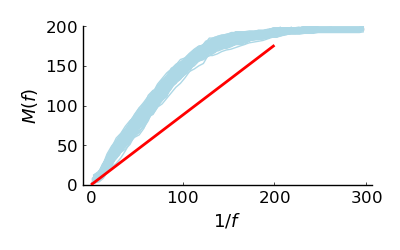

In [411]:
let mutnumb = 200
    fig = plot(size=(400,250), legend=:none, tickfontsize=12, labelfontsize=13, grid=false, ylims=(0,:auto), margin=5Plots.mm)
    for _=1:200
        ccf, _ = load_turnovertumors(ccf_raw; mutnumb = 200, Nthresh_orph = 10000, res = 0, sample_cutoff = 0)

        mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

        M!(fig, [freqs[m] for m=mutations], nbins=50, lab="", size=(400,250), res=1/300, c=:lightblue, xlab=L"1/f", ylab=L"M(f)")
        
    end
#     plot!(0:1/params[:res], x-> x*2*mu_solve/(1-d_solve), lab=L"\mu \beta", legend=:bottomright, lw=1.5, c=:red, alpha=0.2)
    plot!(0:200, x-> x*mu_solve/(1-d_solve), lab=L"\mu \beta", lw=2., c=:red)
end

In [167]:
Nscale = 100_000

100000

0.37443652386162835
0.14267733847944303
0.64166502882015


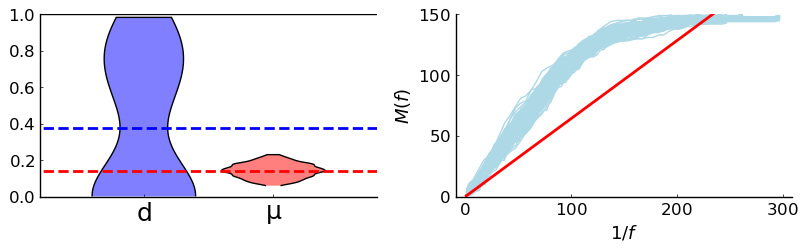

In [168]:
params = (
    Nthresh_orph = 70,
    Nthresh_estr = 20,
    res = 1/3/23,
    sample_cutoff = 1/3,
)

let mutnumb = 150
    dsolves = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

        d_solve = min(1., 2*log(params[:Nthresh_orph]*Nscale)*W_l)
    end
    d_solve = mean(filter(x-> !(iszero(x) || isone(x)), dsolves))

    musolves = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve
        catch e
            NaN
        end
    end
    
    mubetas = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

        d_solve = min(1., 2*log(params[:Nthresh_orph]*Nscale)*W_l)
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))- W_c, 0.01, 0.99)
        
            mu_solve / (1-d_solve)
        catch e
            NaN
        end
    end
    filter!(!isone, dsolves)
    filter!(!isnan, dsolves)
    filter!(m -> m!=0.01 && m!=0.99, musolves)
    filter!(!isnan, musolves)
    filter!(!isnan, mubetas)
    filter!(!isequal(Inf), mubetas)
    filter!(x-> x<3, mubetas)

    p = plot(layout=(1,2), size=(800,250), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)
    
    plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
    hline!(p[1], [1], c=:black)
    violin!(p[1], [1], dsolves, c=:blue, fillalpha=0.5)
    hline!(p[1], [mean(dsolves)], c=:blue, lw=2., style=:dash)
#     annotate!(p[1], [(1,-0.1,text(L"d", 18, :center))])
    violin!(p[1], [2], musolves, c=:red, fillalpha=0.5)
    hline!(p[1], [mean(musolves)], c=:red, lw=2., style=:dash)
#     annotate!(p[1], [(2,-0.1,text(L"\mu", 18, :center))])
#     violin!(p[1], [3], mubetas, c=:green, fillalpha=0.5)
#     hline!(p[1], [mean(mubetas)], c=:green, lw=2., style=:dash)
#     annotate!(p[1], [(3,-0.1,text(L"\mu/(1-d)", 18, :center))])
    
    plot!(p[2], tickfontsize=12, labelfontsize=13, ylims=(0,:auto))
    for _=1:200
        ccf, _ = load_turnovertumors(ccf_raw; mutnumb = mutnumb, Nthresh_orph = 10000, res = 0, sample_cutoff = 0)

        mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

        M!(p[2], [freqs[m] for m=mutations], nbins=50, lab="", res=1/300, c=:lightblue, xlab=L"1/f", ylab=L"M(f)")
        
    end
    plot!(p[2], 0:300, x-> x*mean(mubetas), lab=L"\mu \beta", lw=2., c=:red, ylims=(0,mutnumb))
#     plot!(p[2], 0:300, x-> x*mean(mubetas)/(1-mean(dsolves)), lab=L"\mu \beta", lw=2., c=:orange, ylims=(0,mutnumb))
    
    println(mean(dsolves))
    println(mean(musolves))
    println(mean(mubetas))
    plot!()
#     savefig("Turnover/turnover_plots/experimental_data/reprocessed_wes.pdf")
end

0.6697921352372924
0.1634887333941329
0.5521068849443651


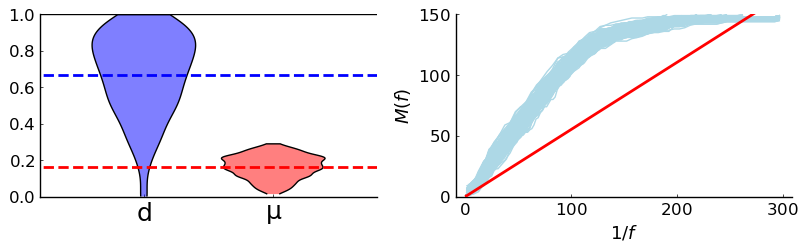

In [108]:
params = (
    Nthresh_orph = 70,
    Nthresh_estr = 20,
    res = 1/3/23,
    sample_cutoff = 1/3,
)

let mutnumb = 150
    dsolves = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
    end
    d_solve = mean(filter(x-> !(iszero(x) || isone(x)), dsolves))

    musolves = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve
        catch e
            NaN
        end
    end
    
    mubetas = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
        
            mu_solve / (1-d_solve)
        catch e
            NaN
        end
    end
    filter!(!isone, dsolves)
    filter!(!isnan, dsolves)
    filter!(m -> m!=0.01 && m!=0.99, musolves)
    filter!(!isnan, musolves)
    filter!(!isnan, mubetas)
    filter!(!isequal(Inf), mubetas)
    filter!(x-> x<3, mubetas)

    p = plot(layout=(1,2), size=(800,250), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)
    
    plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
    hline!(p[1], [1], c=:black)
    violin!(p[1], [1], dsolves, c=:blue, fillalpha=0.5)
    hline!(p[1], [mean(dsolves)], c=:blue, lw=2., style=:dash)
#     annotate!(p[1], [(1,-0.1,text(L"d", 18, :center))])
    violin!(p[1], [2], musolves, c=:red, fillalpha=0.5)
    hline!(p[1], [mean(musolves)], c=:red, lw=2., style=:dash)
#     annotate!(p[1], [(2,-0.1,text(L"\mu", 18, :center))])
#     violin!(p[1], [3], mubetas, c=:green, fillalpha=0.5)
#     hline!(p[1], [mean(mubetas)], c=:green, lw=2., style=:dash)
#     annotate!(p[1], [(3,-0.1,text(L"\mu/(1-d)", 18, :center))])
    
    plot!(p[2], tickfontsize=12, labelfontsize=13, ylims=(0,:auto))
    for _=1:200
        ccf, _ = load_turnovertumors(ccf_raw; mutnumb = mutnumb, Nthresh_orph = 10000, res = 0, sample_cutoff = 0)

        mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

        M!(p[2], [freqs[m] for m=mutations], nbins=50, lab="", res=1/300, c=:lightblue, xlab=L"1/f", ylab=L"M(f)")
        
    end
    plot!(p[2], 0:300, x-> x*mean(mubetas), lab=L"\mu \beta", lw=2., c=:red, ylims=(0,mutnumb))
#     plot!(p[2], 0:300, x-> x*mean(mubetas)/(1-mean(dsolves)), lab=L"\mu \beta", lw=2., c=:orange, ylims=(0,mutnumb))
    
    println(mean(dsolves))
    println(mean(musolves))
    println(mean(mubetas))
    plot!()
#     savefig("Turnover/turnover_plots/experimental_data/reprocessed_wes.pdf")
end

In [113]:
savefig("Turnover/turnover_plots/experimental_data/reprocessed_wes.pdf")

> uncorrected 150

0.532520908833243
0.23376983512304753
0.5191622615590091


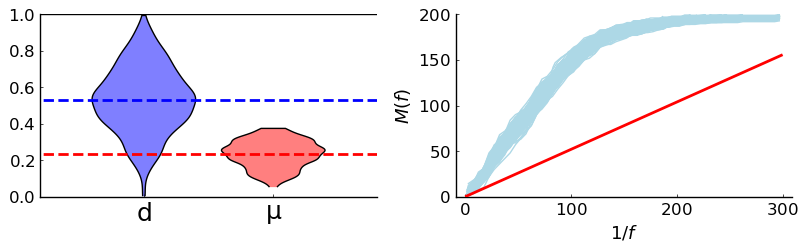

In [191]:
params = (
    Nthresh_orph = 150,
    Nthresh_estr = 50,
    res = 1/150,
    sample_cutoff = 1/3,
)

let mutnumb = 200
    dsolves = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
    end
    d_solve = mean(filter(x-> !(iszero(x) || isone(x)), dsolves))

    musolves = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve
        catch e
            NaN
        end
    end
    
    mubetas = map(1:500) do _
        
        ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = mutnumb, params...)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph

        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> correct_estr
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
        
            mu_solve / (1-d_solve)
        catch e
            NaN
        end
    end
    filter!(!isone, dsolves)
    filter!(!isnan, dsolves)
    filter!(m -> m!=0.01 && m!=0.99, musolves)
    filter!(!isnan, musolves)
    filter!(!isnan, mubetas)
    filter!(!isequal(Inf), mubetas)
    filter!(x-> x<3, mubetas)

    p = plot(layout=(1,2), size=(800,250), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)
    
    plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
    hline!(p[1], [1], c=:black)
    violin!(p[1], [1], dsolves, c=:blue, fillalpha=0.5)
    hline!(p[1], [mean(dsolves)], c=:blue, lw=2., style=:dash)
#     annotate!(p[1], [(1,-0.1,text(L"d", 18, :center))])
    violin!(p[1], [2], musolves, c=:red, fillalpha=0.5)
    hline!(p[1], [mean(musolves)], c=:red, lw=2., style=:dash)
#     annotate!(p[1], [(2,-0.1,text(L"\mu", 18, :center))])
#     violin!(p[1], [3], mubetas, c=:green, fillalpha=0.5)
#     hline!(p[1], [mean(mubetas)], c=:green, lw=2., style=:dash)
#     annotate!(p[1], [(3,-0.1,text(L"\mu/(1-d)", 18, :center))])
    
    plot!(p[2], tickfontsize=12, labelfontsize=13, ylims=(0,:auto))
    for _=1:200
        ccf, _ = load_turnovertumors(ccf_raw; mutnumb = mutnumb, Nthresh_orph = 10000, res = 0, sample_cutoff = 0)

        mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

        M!(p[2], [freqs[m] for m=mutations], nbins=50, lab="", res=1/300, c=:lightblue, xlab=L"1/f", ylab=L"M(f)")
        
    end
    plot!(p[2], 0:300, x-> x*mean(mubetas), lab=L"\mu \beta", lw=2., c=:red, ylims=(0,mutnumb))
#     plot!(p[2], 0:300, x-> x*mean(mubetas)/(1-mean(dsolves)), lab=L"\mu \beta", lw=2., c=:orange, ylims=(0,mutnumb))
    
    println(mean(dsolves))
    println(mean(musolves))
    println(mean(mubetas))
    plot!()
#     savefig("Turnover/turnover_plots/experimental_data/reprocessed_wes.pdf")
end

> corrected

In [174]:
Nscale = 100
params = (
    Nthresh_orph = 70,
    Nthresh_estr = 20,
    sample_cutoff = 1/3,
    res = 1/( 3 * nrow(ccf) ),
)

(Nthresh_orph = 70, Nthresh_estr = 20, sample_cutoff = 0.3333333333333333, res = 0.014492753623188406)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


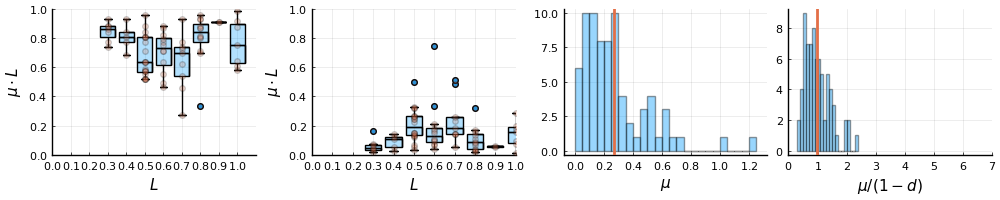

In [176]:
let mutnumb = 200
    
    results = Vector()
    Ls = Float64[]
    @showprogress for L = 0.1:0.1:1.
        for _=1:200
            ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = floor(Int,mutnumb*L), params...)

            # get d
            W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph #|> mes2theory_orphaned

            d_solve = min(1., 2*log(params[:Nthresh_orph]*Nscale)*W_l)

            (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue

            # get mu
            W_c = estranged_treeless(estranged_tumor) |> correct_estr #|> mes2theory_estranged
            try
                mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr]*Nscale)/(1-d_solve)))- W_c, [0.01,0.99], 100)

                push!(results, (d_solve, mu_solve))
                push!(Ls, L)
                catch e
            end

        end
    end
    p = plot(layout=(1,4), legend=:none, size=(1000,200))
    scalex = 10
    
    boxplot!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
    scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
#     hline!(p[1], [mean(getindex.(results, 1))], lw=2.)
    
    boxplot!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
    scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(0,scalex), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
#     plot!(p[2], [0,scalex], [0,mean(getindex.(results,2)[Ls .== 1.])], lw=2.)

    histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
    vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )
    histogram!(p[4], getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)), xlim=(0,7), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
    vline!(p[4], [mean(getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))], lw=2. )
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


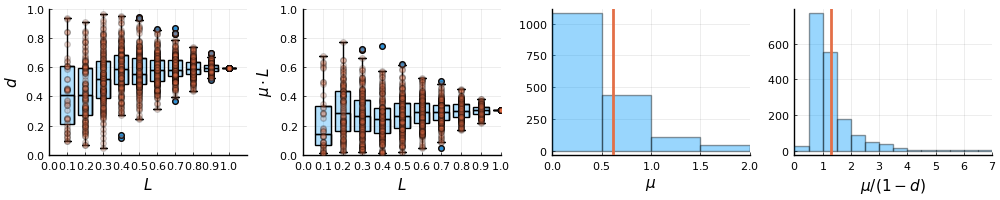

In [28]:
params = (
    Nthresh_orph = 150,
    Nthresh_estr = 50,
    res = 1/150,
    sample_cutoff = 1/3,
)

let mutnumb = 700
    
    results = Vector()
    Ls = Float64[]
    @showprogress for L = 0.1:0.1:1.
        for _=1:200
            ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = floor(Int,mutnumb*L), params...)

            # get d
            W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph #|> mes2theory_orphaned

            d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)

            (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue

            # get mu
            W_c = estranged_treeless(estranged_tumor) |> correct_estr #|> mes2theory_estranged
            try
                mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)

                push!(results, (d_solve, mu_solve))
                push!(Ls, L)
                catch e
            end

        end
    end
    p = plot(layout=(1,4), legend=:none, size=(1000,200))
    scalex = 10
    
    boxplot!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
    scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"d")
#     hline!(p[1], [mean(getindex.(results, 1))], lw=2.)
    
    boxplot!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
    scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(0,scalex), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
#     plot!(p[2], [0,scalex], [0,mean(getindex.(results,2)[Ls .== 1.])], lw=2.)

    histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu", xlim=(0,2))
    vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )
    histogram!(p[4], getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)), xlim=(0,7), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
    vline!(p[4], [mean(getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))], lw=2. )
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


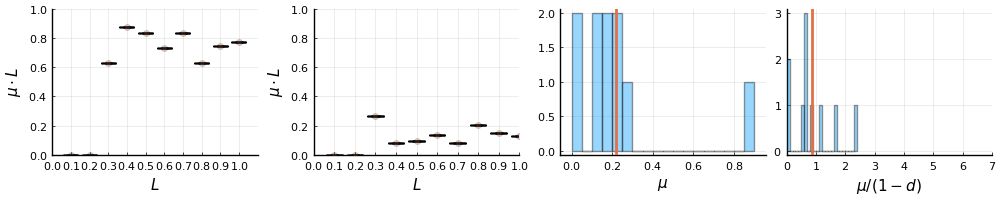

In [51]:
let mutnumb = 100
    
    Ls = collect(0.1:0.1:1.)
    results = Matrix(undef, length(Ls), 2)
    @showprogress for (i,L) = enumerate(Ls)
        ds = map(1:200) do _
            ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = floor(Int,mutnumb*L), params...)

            # get d
            W_l = orphaned_red_treeless(orphaned_tumor) |> correct_orph #|> mes2theory_orphaned

            d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)

            d_solve = (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) ? missing : d_solve
        end
        if all(ismissing.(ds))
            results[i,:] .=  0, 0
            continue
        end
        d_m = median(filter(!ismissing, ds))
            
        mus = map(1:200) do _
            ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = floor(Int,mutnumb*L), params...)
            # get mu
            W_c = estranged_treeless(estranged_tumor) |> correct_estr #|> mes2theory_estranged
            try
                mu_solve, n = bisection(mu -> min(1., W_estranged(d_m; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_m)))- W_c, [0.01,0.99], 100)

                mu_solve
                catch e
                missing
            end
        end
        if all(ismissing.(mus))
            results[i,:] .= d_m, 0
            else 
            results[i,:] .=  d_m, median(filter(!ismissing, mus))
        end
    end
    p = plot(layout=(1,4), legend=:none, size=(1000,200))
    scalex = 10
    
    boxplot!(p[1], scalex*Ls,results[:,1], fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
    scatter!(p[1], scalex*Ls, results[:,1], alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
    
    boxplot!(p[2], scalex*Ls, results[:,2], fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
    scatter!(p[2], scalex*Ls, results[:,2], alpha=0.2, xlim=(0,scalex), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")

    histogram!(p[3], results[:,2]./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
    vline!(p[3], [mean( results[:,2]./Ls)], lw=2. )
    histogram!(p[4], results[:,2]./Ls ./ (1 .-  results[:,1]), xlim=(0,7), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
    vline!(p[4], [mean( results[:,2]./Ls ./ (1 .-  results[:,1]))], lw=2. )
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


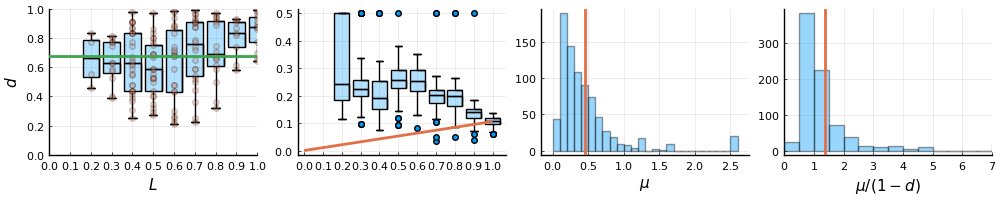

In [556]:
let mutnumb = 250
    
    ds = Float64[]
    mus = Float64[]
    d_mu = Float64[]
    Ls_d = Float64[]
    Ls_mu = Float64[]
    @showprogress for L = 0.2:0.1:1.
        d_L = map( 1:100 ) do _
            ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = floor(Int,mutnumb*L), params...)

            # get d
            W_l = orphaned_red_treeless(orphaned_tumor) |>
                    df -> sum(df.isorphaned)/sum(df.isgreen) #|> mes2theory_orphaned
            
            d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        end
        filter!(d -> !( isnan(d) || isone(d) || iszero(d) ), d_L)
        append!(ds, d_L)
        append!(Ls_d, fill(L, length(d_L)))
        d_solve = mean(d_L)
        
        for _=1:100
            
            ccf, orphaned_tumor, estranged_tumor = load_turnovertumors(ccf_raw; mutnumb = floor(Int,mutnumb*L), params...)
            
            # get mu
            W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen) #|> mes2theory_estranged
            try
                mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)

                push!(mus, mu_solve)
                push!(d_mu, d_solve)
                push!(Ls_mu, L)
                catch e
            end
        end
    end
    scalex = 10
    
    p = plot(layout=(1,4), legend=:none, size=(1000,200))
    boxplot!(p[1], scalex*Ls_d, ds, fillalpha=0.3)
    scatter!(p[1], scalex*Ls_d, ds, alpha=0.2, xlim=(0,scalex), ylim=(0,1), xlab = L"L", ylab=L"d")
    hline!(p[1], [mean(ds)], lw=2., xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
    
    boxplot!(p[2], scalex*Ls_mu, mus, fillalpha=0.3)
    scatter!(p[2], scalex*Ls_mu, mus, alpha=0.2, xlim=(0,scalex), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
    plot!(p[2], [0,scalex], [0,mean(mus[Ls_mu .== 1.])], lw=2., xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))

    histogram!(p[3], mus./Ls_mu, nbins=30, alpha=0.4, xlab = L"\mu")
    vline!(p[3], [mean(mus./Ls_mu)], lw=2. )
    histogram!(p[4], mus./Ls_mu ./ (1 .- d_mu), xlim=(0,7), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
    vline!(p[4], [mean(mus./Ls_mu ./ (1 .- d_mu))], lw=2. )
end

In [29]:
mu_solve = 0.2
mu_solve/(1-d_solve)

0.9090909090909093

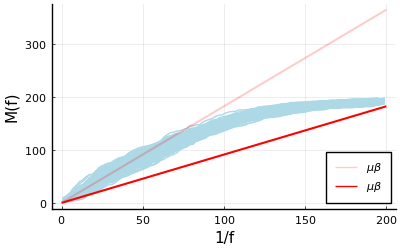

In [34]:
let mutnumb = 200
    fig = plot()
    for _=1:200
        ccf, _ = load_turnovertumors(ccf_raw; mutnumb = 200, Nthresh_orph = 10000, res = 0, sample_cutoff = 0)

        mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

        M!(fig, [freqs[m] for m=mutations], nbins=50, lab="", size=(400,250), res=res, c=:lightblue)
        
    end
    plot!(0:1/res, x-> x*2*mu_solve/(1-d_solve), lab=L"\mu \beta", legend=:bottomright, lw=1.5, c=:red, alpha=0.2)
    plot!(0:1/res, x-> x*mu_solve/(1-d_solve), lab=L"\mu \beta", legend=:bottomright, lw=1.5, c=:red)
end

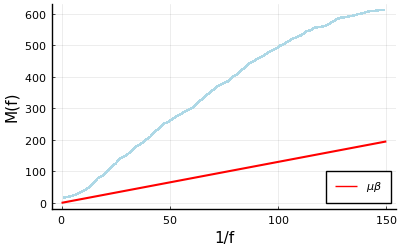

In [32]:
let mutnumb = 700
    fig = plot()
    for _=1:200
        ccf, _ = load_turnovertumors(ccf_raw; mutnumb = mutnumb, Nthresh_orph = 10000, res = 0, sample_cutoff = 0)

        mutations, freqs = SeqDataFormatting.mfreqs(ccf) |> df -> (df.mutation, Dict( df.mutation .=> df.frequency ))

        M!(fig, [freqs[m] for m=mutations], nbins=50, lab="", size=(400,250), res=params[:res], c=:lightblue)
        
    end
    plot!(0:1/params[:res], x-> x*1.3, lab=L"\mu \beta", legend=:bottomright, lw=1.5, c=:red)
end